# Simulating the observed period distribution

In [1]:
from math import *
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.labelspacing':0.25, 'legend.fontsize': 12})
mpl.rcParams.update({'errorbar.capsize': 4})

## Draw distributions for initial periods, magnetic fields and actual ages

(array([2., 3., 0., 2., 4., 0., 2., 1., 4., 2., 3., 2., 3., 1., 0., 3., 0.,
        3., 3., 1., 1., 3., 4., 4., 1., 0., 3., 1., 0., 4.]),
 array([ 1457.13818958,  4722.87618681,  7988.61418403, 11254.35218126,
        14520.09017848, 17785.82817571, 21051.56617293, 24317.30417015,
        27583.04216738, 30848.7801646 , 34114.51816183, 37380.25615905,
        40645.99415628, 43911.7321535 , 47177.47015072, 50443.20814795,
        53708.94614517, 56974.6841424 , 60240.42213962, 63506.16013685,
        66771.89813407, 70037.63613129, 73303.37412852, 76569.11212574,
        79834.85012297, 83100.58812019, 86366.32611742, 89632.06411464,
        92897.80211186, 96163.54010909, 99429.27810631]),
 <BarContainer object of 30 artists>)

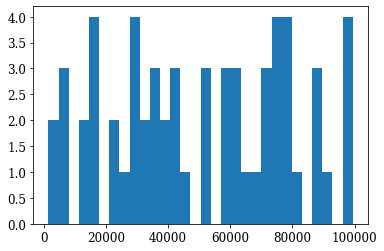

In [2]:
N = 60
np.random.seed(12598624) ## Fix seed to get the same result in each run
t  = np.random.uniform   (1000, 100000, size=N)
P0 = np.random.normal    (-1.04, 0.42, size=N) ## -0.96, 0.43
P0 = np.power (10.0, P0)
B0 = np.random.normal    (12.44, 0.44, size=N)
B0 = np.power (10.0, B0)
P = np.sqrt(P0*P0 + 2*B0*B0 / 1.024e39 * t * 3.154e+7)

t_meas = []
for i in range (0, len(t)):
    tl = 0.5*t[i]
    tr = 1.5*t[i]
    tv = np.random.uniform(tl, tr)
    t_meas.append(tv)

plt.hist(t, 30)

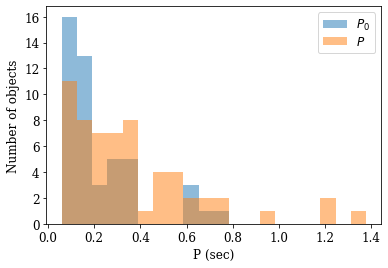

In [3]:
plt.hist (P0, 20, range=[np.min(P), np.max(P)], alpha=0.5, label=r'$P_0$')
plt.hist (P, 20, range=[np.min(P), np.max(P)], alpha=0.5, label=r'$P$')
plt.xlabel('P (sec)')
plt.ylabel('Number of objects')
plt.legend()
plt.savefig('P_simul.pdf')

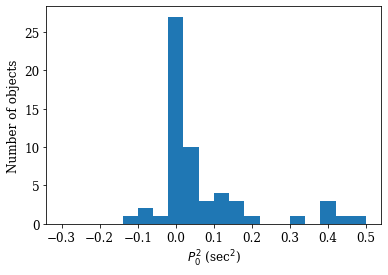

In [4]:
P0_est2 = P*P - 2*B0*B0 / 1.024e39 * t_meas * 3.154e+7
plt.hist(P0_est2, 20, range=[-0.3, 0.5])
plt.xlabel(r'$P_0^2$ (sec$^2$)')
plt.ylabel('Number of objects')
plt.savefig('p_est2.pdf')


Text(0, 0.5, "t' (years)")

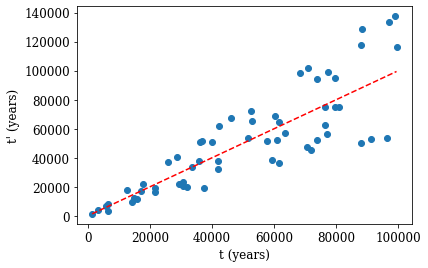

In [5]:
x = np.linspace (np.min(t), np.max(t), 1000)
plt.scatter (t, t_meas)
plt.plot (x,x, 'r--')
plt.xlabel('t (years)')
plt.ylabel('t\' (years)')

## Constructing log-likelihood

(0.9993226199709176, 7.159819075116243e-10) 1.0006778391838085


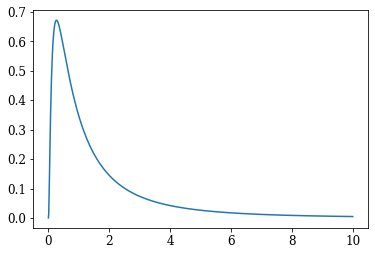

In [6]:
## pdf for initial period distribution
## receives P0^2 and rejects negative values
def Pp0 (x2, mu, sigma):
    if x2 >= 0:
        x = sqrt(x2)
        res = log10(e) / (x*sigma*sqrt(2.0*pi)) * np.exp( - (np.log10(x) - mu)**2.0 / (2.0*(sigma**2.0)))
    else:
        res = 0.0
    return res

## testing that the distribution is properly normalised
x = np.linspace(0.001,10.0, 1000)
y = []
for i in range (len(x)):
    y.append (Pp0 (x[i]**2, 0.0, 0.5))
val = integrate.quad(lambda x: Pp0(x**2.0, 0.0, 0.5), 0, 40.0) #np.sum(y) * (x[1] - x[0])
print (val, 1.0 / val[0])
plt.plot (x,y)

In [7]:
## Likelihood for single pulsar
def P0comp2 (P, B0, t):
    res = P*P - 2.0 * B0*B0 * t / 1.024e39 * 3.154e+7 
    return res
def P0comp  (P, B0, t):
    res = P*P - 2.0 * B0*B0 * t / 1.024e39 * 3.154e+7
    if res > 0:
        return sqrt(res)
    else:
        return 1.0
def one (P, B0, t):
    val = P - sqrt(2.0 * B0*B0 * t / 1.024e39 * 3.154e+7)
    if val > 0:
        return 1.0
    else:
        return 0.0
    
def int_func (t, P, B0, mup, sigmap):
    res = np.full_like(t, 0)
    for i in range (0, len(t)):
        res[i] = one (P, B0, t[i])*Pp0(P0comp2 (P, B0, t[i]), mup, sigmap) / P0comp  (P, B0, t[i])
    return res
        
    
    
def likel (P, B0, t_meas, mup, sigmap, trange_flag = False, tlv = 0.0, trv = 0):
    if trange_flag:
        #print ('We use ranges: ', tlv, trv)
        tl = tlv
        tr = trv
    else:
        tl = 0.66*t_meas
        tr = 2.0*t_meas
    #res = integrate.fixed_quad(lambda x: , tl, tr, n=20)[0] * P / t_meas
    res = integrate.fixed_quad (int_func, tl, tr, n=100, args=(P, B0, mup, sigmap)) [0] * P / t_meas
    return res

def likel_insp (P, B0, t_meas, mup, sigmap):
    tl = 0.66*t_meas
    tr = 2.0*t_meas
    x = np.linspace (tl, tr, 100)
    res = 0.0
    for i in range (0, len(x)):
        v = one (P, B0, x[i])*Pp0(P0comp2 (P, B0, x[i]), mup, sigmap) / P0comp  (P, B0, x[i]) * P / t_meas * (x[1] - x[0])
        #print (i, v)
        res += v
    return res

## Log-likelihood for all radio pulsars in the catalogue
def loglikel (x0, P, B0, t_meas, print_details = False, trange_flag = False, tlv = 0.0, trv = 0):
    mup, sigmap = x0
    res = 0.0
    for i in range (0, len(P)):
        likel_v =likel (P[i], B0[i], t_meas[i], mup, sigmap)
        #likel_v1 = likel_insp (P[i], B0[i], t_meas[i], mup, sigmap)
        #print (i, likel_v, likel_v1)
        if likel_v > 0:
            res = res + log(likel_v)
        if (print_details) and isnan(likel_v):
            print ('i is ', i, res)
    return -res

## Log-likelihood for all radio pulsars in the catalogue with fixed integration ranges
def loglikel_r (x0, P, B0, t_meas, tlv, trv, print_details = False):
    mup, sigmap = x0
    res = 0.0
    for i in range (0, len(P)):
        likel_v =likel (P[i], B0[i], t_meas[i], mup, sigmap, trange_flag=True, tlv=tlv[i], trv=trv[i])
        #likel_v1 = likel_insp (P[i], B0[i], t_meas[i], mup, sigmap)
        #print (i, likel_v, likel_v1)
        if likel_v > 0:
            res = res + log(likel_v)
        if (print_details) and isnan(likel_v):
            print ('i is ', i, res)
    return -res    

In [8]:
## Here we print the log-likelihood for the value which we assumed when we generated the population
print (loglikel ([-0.96, 0.43], P, B0, t_meas))
print (len(P), len(B0), len(t_meas))

-68.8028042481507
60 60 60


In [9]:
x0 = [-0.2, 0.1]
res_synth_lognorm = minimize(loglikel, x0, method='nelder-mead', args=(P, B0, t_meas))
print (res_synth_lognorm)

 final_simplex: (array([[-1.0078416 ,  0.44430295],
       [-1.00780679,  0.44431905],
       [-1.00777307,  0.44424698]]), array([-69.0446853 , -69.04468526, -69.04468507]))
           fun: -69.04468530291317
       message: 'Optimization terminated successfully.'
          nfev: 100
           nit: 55
        status: 0
       success: True
             x: array([-1.0078416 ,  0.44430295])


In [10]:
## Inspect the best solution, which pulsars are not included? 
x0 = res_synth_lognorm.x
loglikel (x0, P, B0, t_meas, print_details = True)

-69.04468530291317

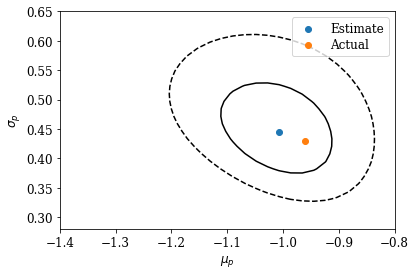

In [11]:
## Here we draw contours for synthetic data
NN = 30
mup    = np.linspace (-1.4, -0.8, NN)
sigmap = np.linspace ( 0.28, 0.65, NN)

X,Y = np.meshgrid(mup, sigmap)

Z = np.zeros((NN,NN))
for i in range (NN):
    for j in range (NN):
        p1 = loglikel ([X[i,j], Y[i,j]], P, B0, t_meas)
        Z[i,j] = p1
        
plt.contour(X,Y,Z, [res_synth_lognorm.fun, res_synth_lognorm.fun+1, res_synth_lognorm.fun+3.32], colors='black', linestyles=['solid', 'solid', 'dashed'])
plt.scatter ([res_synth_lognorm.x[0]], [res_synth_lognorm.x[1]], label='Estimate')
plt.scatter ([-0.96], [0.43], label='Actual')
plt.xlabel(r'$\mu_p$')
plt.ylabel(r'$\sigma_p$')
plt.legend()
plt.savefig('assumed_restored.pdf')

## Constructing log-likelihood for another distribution i.e. initial periods are normally distributed

0.5036435874322407
(0.9999999999999999, 8.67103220795291e-10)


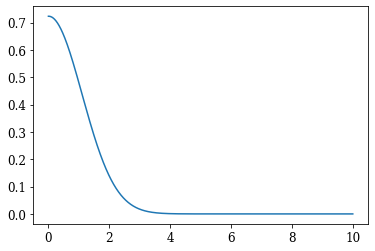

In [12]:
## pdf for initial period distribution
def Pp0norm (x2, mu, sigma): 
    if x2 >= 0:
        x = sqrt(x2)
        C = 1.0 / (1.0 - 0.5 * (1.0 + erf(-mu/(sigma*sqrt(2)))) ) 
        res = C / (sigma*sqrt(2.0*pi)) * np.exp( - (x - mu)**2.0 / (2.0*(sigma**2.0)))
    else:
        res = 0.0
    return res

mu = 0.01
sigma = 1.09490095
print (1.0 - 0.5 * (1.0 + erf(-mu/(sigma*sqrt(2)))))
## testing that the distribution is properly normalised
x = np.linspace(0.001,10.0, 1000)
y = []
for i in range (len(x)):
    y.append(Pp0norm (x[i]**2.0, mu , sigma))
val = integrate.quad(lambda x: Pp0norm(x**2.0, 0.0, 0.5), 0, 40.0) #val = np.sum(y) * (x[1] - x[0])
print (val)
plt.plot (x,y)



In [13]:
def int_func_norm (t, P, B0, mup, sigmap):
    res = np.full_like (t, 0)
    for i in range (0, len(t)):
        res[i] = Pp0norm(P0comp2 (P, B0, t[i]), mup, sigmap) / P0comp  (P, B0, t[i])
    return res

## Likelihood for single pulsar
def likel_norm (P, B0, t_meas, mup, sigmap, trange_flag = False, tlv = 0.0, trv = 0):
    if trange_flag:
        tl = tlv
        tr = trv
    else:
        tl = 0.66*t_meas
        tr = 2.0*t_meas
    #res = integrate.quad(lambda x: Pp0norm(P0comp2 (P, B0, x), mup, sigmap) / P0comp  (P, B0, x), tl, tr)[0] * P / t_meas
    res = integrate.fixed_quad (int_func_norm, tl, tr, n=100, args=(P, B0, mup, sigmap))[0] * P / t_meas
    return res

## Log-likelihood for all radio pulsars in the catalogue
def loglikel_norm (x0, P, B0, t_meas):
    mup, sigmap = x0
    res = 0.0
    for i in range (0, len(P)):
        likel_v =likel_norm (P[i], B0[i], t_meas[i], mup, sigmap)
        if likel_v > 0:
            res = res + log(likel_v)
        #else:
            #print ('likel_v is 0', i, res)
            #res = res - 100.0 
        #print (i, res)
    return -res   

## Log-likelihood for all radio pulsars in the catalogue when SNR age ranges are fixed
def loglikel_norm_r (x0, P, B0, t_meas, tlv, trv):
    mup, sigmap = x0
    res = 0.0
    for i in range (0, len(P)):
        likel_v =likel_norm (P[i], B0[i], t_meas[i], mup, sigmap, trange_flag = True, tlv=tlv[i], trv=trv[i])
        if likel_v > 0:
            res = res + log(likel_v)
        #else:
            #print ('likel_v is 0', i, res)
            #res = res - 100.0 
        #print (i, res)
    return -res    

In [14]:
x0 = [0.2, 0.2]
res_norm = minimize(loglikel_norm, x0, method='nelder-mead', bounds=([0.01, 2], [0.01, 2]), args=(P, B0, t_meas))
print(res_norm)

 final_simplex: (array([[0.01      , 0.24547333],
       [0.01      , 0.24542364],
       [0.01      , 0.24549248]]), array([-60.00519955, -60.00519942, -60.00519841]))
           fun: -60.00519955189554
       message: 'Optimization terminated successfully.'
          nfev: 45
           nit: 25
        status: 0
       success: True
             x: array([0.01      , 0.24547333])


In [15]:
## Here we compare two hypothesis using AIC. 
print (res_norm.fun - res_synth_lognorm.fun)

9.03948575101763


# Analysis of actual data

### Reading the catalogue

In [31]:
## Read and filter data from our file
f = open ('clean_NSPSRlist.txt','r')
name_psr = []
snr_name = []
flag     = []
B        = []
log10B   = []
Pa       = []
dotP     = []
P0       = []
age_SNR  = []
tau      = []
B_psr    = []
log10B_psr = []
at = []
bt = []

for lines in f.readlines():
    line = lines.split('\t')
    name_psr.append (line[0])
    snr_name.append (line[1])
    flag.append (line[2])
    B.append (float(line[3]))
    log10B.append (log10(B[-1]))
    Pa.append (float(line[4]))
    dotP.append (float(line[5]))
    P0.append (float(line[6]))
    age_SNR.append (float(line[7]))
    tau.append (float(line[8]))
    at.append  (float(line[9]))
    bt.append  (float(line[10]))
#    if flag[-1] == 'PSR':
#        B_psr.append (float())

log10B_psr  = [log10B[i] for i in range (0, len(flag)) if flag[i] == 'PSR']
name_psrpsr = [name_psr[i]  for i in range (0, len(Pa)) if flag[i] == 'PSR' ]
snr_namepsr = [snr_name[i]  for i in range (0, len(Pa)) if flag[i] == 'PSR' ]
P_psr       = [Pa[i]  for i in range (0, len(Pa)) if flag[i] == 'PSR' ]
B0_psr      = [B[i]  for i in range (0, len(B))  if flag[i] == 'PSR']
P0_psr      = [P0[i] for i in range (0, len(P0)) if flag[i] == 'PSR']
P0_psr_sel  = [P0[i] for i in range (0, len(P0)) if flag[i] == 'PSR' and P0[i] > 0.01 and P0[i] < 2] 
age_SNR_psr = [age_SNR[i] for i in range (0, len(age_SNR)) if flag[i] == 'PSR']
at_psr      = [at[i] for i in range (0, len(P0)) if flag[i] == 'PSR']
bt_psr      = [bt[i] for i in range (0, len(P0)) if flag[i] == 'PSR']

## Let't inspect first few records, to be sure that we analyse the correct data
for i in range (0, 5):
    print (name_psrpsr[i], snr_namepsr[i], P_psr[i], B0_psr[i], age_SNR_psr[i], at_psr[i], bt_psr[i])
    
print ('We will work with: ', len(P_psr), ' records')

AXS J1617-5055  G332.4-00.4 0.069356847 3100000000000.0 3200.0 2000.0 4400.0
J0002+6216 G116.9+00.2 0.1153635683 840000000000.0 12800.0 7500.0 18100.0
J0007+7303 G119.5+10.2 0.3158731909 10800000000000.0 13000.0 13000.0 13000.0
J0205+6449 G130.7+03.1 0.06571592849 3610000000000.0 3500.0 0.0 7000.0
J0215+6218 G132.7+01.3 0.5488798192 610000000000.0 29000.0 25000.0 33000.0
We will work with:  45  records


## Assumption B. Extended integration limits.  

In [17]:
## Search the maximum
x0 = [-0.2, 0.5]
res = minimize(loglikel, x0, method='nelder-mead', args=(P_psr, B0_psr, age_SNR_psr))
print (res)

 final_simplex: (array([[-1.13496514,  0.54830977],
       [-1.1349428 ,  0.54837522],
       [-1.13492291,  0.54826273]]), array([-53.4532947 , -53.45329452, -53.45329449]))
           fun: -53.45329469670468
       message: 'Optimization terminated successfully.'
          nfev: 90
           nit: 48
        status: 0
       success: True
             x: array([-1.13496514,  0.54830977])


In [18]:
## Inspect the best solution, which pulsars are not included? 
x0 = res.x
loglikel (x0, P_psr, B0_psr, age_SNR_psr, print_details = True)

-53.45329469670468

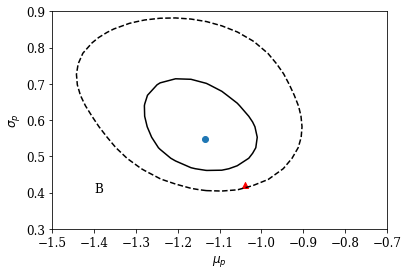

In [47]:
## Plot contours
NN = 20
mup    = np.linspace (-1.5, -0.8, NN)
sigmap = np.linspace ( 0.35, 0.9, NN)

X,Y = np.meshgrid(mup, sigmap)

Z = np.zeros((NN,NN))
for i in range (NN):
    for j in range (NN):
        p1 = loglikel ([X[i,j], Y[i,j]], P_psr, B0_psr, age_SNR_psr)
        Z[i,j] = p1
plt.contour(X,Y,Z, [res.fun, res.fun+1, res.fun+3.32], colors='black', linestyles=['solid', 'solid', 'dashed'])
plt.scatter ([res.x[0]], [res.x[1]], label='Estimate')
plt.xlabel(r'$\mu_p$')
plt.ylabel(r'$\sigma_p$')
plt.xlim([-1.5, -0.7])
plt.ylim([0.3, 0.9])
plt.text(-1.4, 0.4, 'B')
plt.scatter ([-1.04], [0.42], marker='^', color='red')
plt.savefig ('lognormal_contour_B.pdf')
#plt.legend()

In [20]:
## Here we analyse a hypothesis that the initial period distribution is normal
x0 = [0.2, 0.2]
res_norm = minimize(loglikel_norm, x0, method='nelder-mead', bounds=([-10, 2], [0.01, 2]), args=(P_psr, B0_psr, age_SNR_psr))
print (res_norm)

 final_simplex: (array([[-10.        ,   1.41404682],
       [-10.        ,   1.41404682],
       [-10.        ,   1.41404677]]), array([-42.99868903, -42.99868866, -42.99860274]))
           fun: -42.99868902911733
       message: 'Optimization terminated successfully.'
          nfev: 145
           nit: 67
        status: 0
       success: True
             x: array([-10.        ,   1.41404682])


In [22]:
print (res_norm.fun - res.fun)

10.454605667587352


0.988408451225481


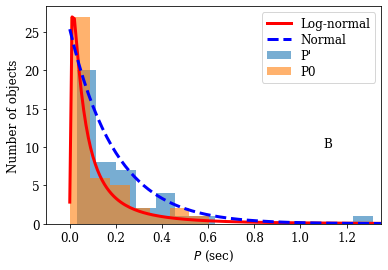

In [35]:
x = np.linspace(0.001,10.0, 1000)
#y = Pp0 (x, -1.19906617,  0.62306521)
y = []
z = []
for i in range (len(x)):
    y.append(Pp0     (x[i]**2.0, res.x[0],  res.x[1]))
    #z.append(Pp0norm (x[i]**2.0, 0.01, 0.48))
    z.append(Pp0norm (x[i]**2.0, res_norm.x[0], res_norm.x[1]))
val = np.sum(y) * (x[1] - x[0])
print (val)
y = np.asarray(y)
z = np.asarray(z)
plt.plot (x,y*2.9, 'r-', linewidth=3, label='Log-normal')
plt.plot (x,z*5,    'b--', linewidth=3, label='Normal')
plt.hist (P_psr, 32, alpha=0.6, label='P\'')
plt.hist (P0_psr, 32, alpha=0.6, label='P0')
plt.xlim([-0.1, 1.35])
plt.legend()
plt.xlabel(r'$P$ (sec)')
plt.ylabel('Number of objects')
plt.text(1.1, 10, 'B')
plt.savefig('periods_lognorm_B.pdf')

In [24]:
## Let's compute KS test
P0_synth = np.random.normal    (res.x[0],  res.x[1], size=60) 
P0_synth = np.power (10.0, P0_synth)

stats.kstest(P0_psr, P0_synth)


KstestResult(statistic=0.18333333333333332, pvalue=0.3195847560749425)

## Assumption A. Analysis with fixed ranges of SNR age. Model: log-normal

In [25]:
## Search the maximum
x0 = [-0.2, 0.5]
res_fixed_range_lognorm = minimize(loglikel_r, x0, method='nelder-mead', args=(P_psr, B0_psr, age_SNR_psr, at_psr, bt_psr))
print (res_fixed_range_lognorm)



 final_simplex: (array([[-1.04157138,  0.53122358],
       [-1.0416246 ,  0.5312117 ],
       [-1.04165139,  0.5312774 ]]), array([-15.76562867, -15.76562858, -15.76562831]))
           fun: -15.765628668480606
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 46
        status: 0
       success: True
             x: array([-1.04157138,  0.53122358])


In [26]:
## Inspect the best solution, which pulsars are not included? 
x0 = res_fixed_range_lognorm.x
loglikel_r (x0, P_psr, B0_psr, age_SNR_psr, at_psr, bt_psr, print_details = True)

-15.765628668480606

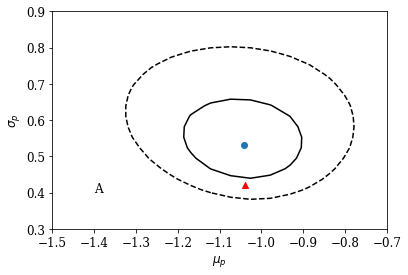

In [46]:
## Plot contours
NN = 20
mup    = np.linspace (-1.5, -0.6, NN)
sigmap = np.linspace ( 0.35, 0.9, NN)

X,Y = np.meshgrid(mup, sigmap)

Z = np.zeros((NN,NN))
for i in range (NN):
    for j in range (NN):
        p1 = loglikel_r ([X[i,j], Y[i,j]], P_psr, B0_psr, age_SNR_psr, at_psr, bt_psr)
        Z[i,j] = p1
plt.contour(X,Y,Z, [res_fixed_range_lognorm.fun, res_fixed_range_lognorm.fun+1, res_fixed_range_lognorm.fun+3.32], colors='black', linestyles=['solid', 'solid', 'dashed'])
plt.scatter ([res_fixed_range_lognorm.x[0]], [res_fixed_range_lognorm.x[1]], label='Estimate')
plt.xlabel(r'$\mu_p$')
plt.ylabel(r'$\sigma_p$')
plt.xlim([-1.5, -0.7])
plt.ylim([0.3, 0.9])
plt.text(-1.4, 0.4, 'A')
plt.scatter ([-1.04], [0.42], marker='^', color='red')
plt.savefig ('lognormal_contour_ranges_SNR_A.pdf')

###  Assumption A. Testing the normal distribution assuming that ranges of SNR age are fixed

In [28]:
x0 = [0.2, 0.2]
res_norm_r = minimize(loglikel_norm_r, x0, method='nelder-mead', bounds=([-10, 2], [0.01, 2]), args=(P_psr, B0_psr, age_SNR_psr, at_psr, bt_psr))
print (res_norm_r)

 final_simplex: (array([[-10.        ,   1.55798347],
       [-10.        ,   1.55797308],
       [-10.        ,   1.55788893]]), array([-6.71332688, -6.71331761, -6.71327811]))
           fun: -6.713326877090617
       message: 'Optimization terminated successfully.'
          nfev: 109
           nit: 57
        status: 0
       success: True
             x: array([-10.        ,   1.55798347])


In [29]:
print (res_norm_r.fun - res_fixed_range_lognorm.fun)

9.052301791389988


0.9928550615081465


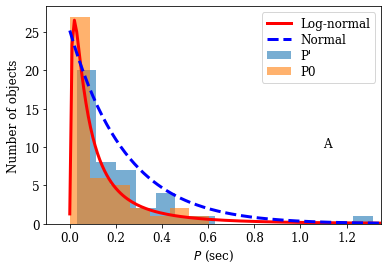

In [43]:
x = np.linspace(0.001,10.0, 1000)
#y = Pp0 (x, -1.19906617,  0.62306521)
y = []
z = []
for i in range (len(x)):
    y.append(Pp0     (x[i]**2.0, res_fixed_range_lognorm.x[0],  res_fixed_range_lognorm.x[1]))
    #z.append(Pp0norm (x[i]**2.0, 0.01, 0.48))
    z.append(Pp0norm (x[i]**2.0, res_norm_r.x[0], res_norm_r.x[1]))
val = np.sum(y) * (x[1] - x[0])
print (val)
y = np.asarray(y)
z = np.asarray(z)
plt.plot (x,y*3.5, 'r-', linewidth=3, label='Log-normal')
plt.plot (x,z*6,    'b--', linewidth=3, label='Normal')
plt.hist (P_psr, 32, alpha=0.6, label='P\'')
plt.hist (P0_psr, 32, alpha=0.6, label='P0')
plt.xlim([-0.1, 1.35])
plt.legend()
plt.xlabel(r'$P$ (sec)')
plt.ylabel('Number of objects')
plt.text(1.1, 10, 'A')
plt.savefig('periods_lognorm_r_A.pdf')